# "Conventional" Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv("../data/final/preprocessed_full.csv", index_col=[0])

# Drop 2022 & 2023
data = data[data["year"] < 2022]

# Also MinMax-scaling what will be target; but saving orig. min and
#  max so we can rescale later:
omin, omax = data["net_migration"].min(), data["net_migration"].max()
data["net_migration"] = minmax_scale(data["net_migration"])

data = data.sort_values(["iso3", "year"]).reset_index(drop=True)

# Construct outcome
data["net_migration_tp1"] = data.groupby(by="iso3").shift(-1)["net_migration"]
data = data.dropna(subset="net_migration_tp1")

# Features & target:
target = "net_migration_tp1"
features = data.drop(["iso3", "year", target], axis=1).columns.tolist()

In [3]:
def collect_metrics(y: np.array, y_hat: np.array) -> dict:
    metrics = {
        "MSE": mean_squared_error(y, y_hat),
        "RMSE": np.sqrt(mean_squared_error(y, y_hat)),
        "MAE": mean_absolute_error(y, y_hat),
        "R-squared": r2_score(y, y_hat)
    }

    return metrics

In [4]:
train = data[data["year"] < 2016]
val = data[data["year"].isin([2016, 2017])]
test = data[data["year"] == 2018]

X_train, y_train = train[features], train[target]
X_val, y_val = val[features], val[target]
X_test, y_test = test[features], test[target]

## Lasso-Regression

Lasso-regression with lagged dependent variable, country dummies & year dummies ("two-way fixed-effects").

In [6]:
lasso = Lasso()
lasso_params = {"alpha": np.arange(1e-6, 1e-4, 1e-6)}
#^ while the upper bound for alpha is technically Inf, we saw in testing that the penalty needs to be extremely small.
lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring="neg_mean_squared_error", verbose=1, n_jobs=-1)
lasso_search.fit(X_train, y_train)
print("Best Alpha:", lasso_search.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Alpha: {'alpha': 1.1e-05}


In [7]:
lasso_best = lasso_search.best_estimator_
y_hat_test_lasso = lasso_best.predict(X_test)

collect_metrics(y_test, y_hat_test_lasso)

{'MSE': 0.00010041079289172883,
 'RMSE': 0.010020518593951554,
 'MAE': 0.005199912980223928,
 'R-squared': 0.936195944386305}

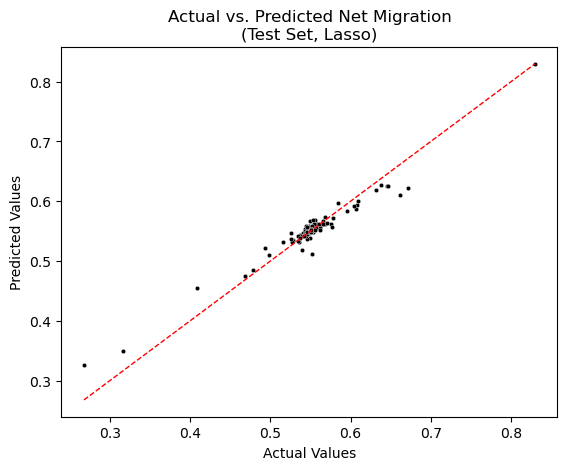

In [8]:
y_hat_test_lasso = lasso_best.predict(X_test)
sns.scatterplot(x=y_test, y=y_hat_test_lasso, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_lasso))
max_val = max(max(y_test), max(y_hat_test_lasso))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, Lasso)")
plt.show()

Most important features (by absolute coefficient):

In [9]:
coefs = pd.DataFrame({
    "feature": X_train.columns,
    "abs_coef": abs(lasso_best.coef_)
})

coefs.sort_values("abs_coef", ascending=False)[:10]

,feature,abs_coef
0,net_migration,0.638922
213,USA,0.091924
8,population,0.086945
28,BGD,0.027555
46,CHN,0.023591
160,PAK,0.022497
135,MEX,0.018860
16,ARE,0.014552
60,DEU,0.013671
175,RUS,0.012404


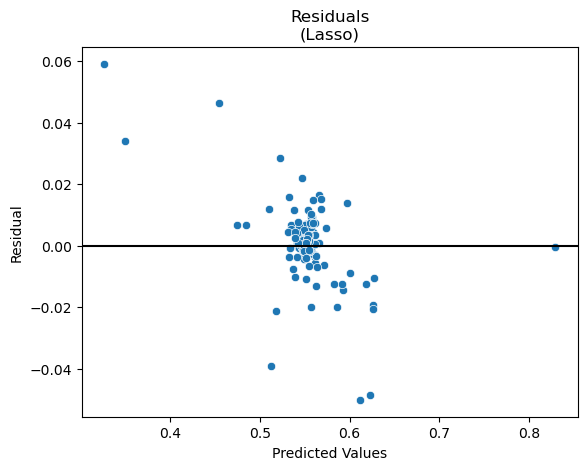

In [10]:
error_lasso = y_hat_test_lasso - y_test
sns.scatterplot(x=y_hat_test_lasso, y=error_lasso)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(Lasso)')
plt.show()

Forward prediction of validation & test set:

In [11]:
def get_forward_pred(model, country: str) -> pd.DataFrame:
    df = data[(data["iso3"] == country) & (data["year"] >= 2000) & (data["year"] <= 2019)][["year", "net_migration"]].rename(columns={"net_migration": "actual"})
    predictions = pd.DataFrame({
        "year": [2017, 2018, 2019],
        "predicted": [*model.predict(X_val[X_val[country] == 1]), *model.predict(X_test[X_test[country] == 1])]
    })

    df = df.merge(predictions, how="left", on="year")

    return df.melt(id_vars="year", value_vars=["actual", "predicted"], value_name="value", var_name="Values")



Text(0.5, 1.0, 'Model predictions\nUSA')

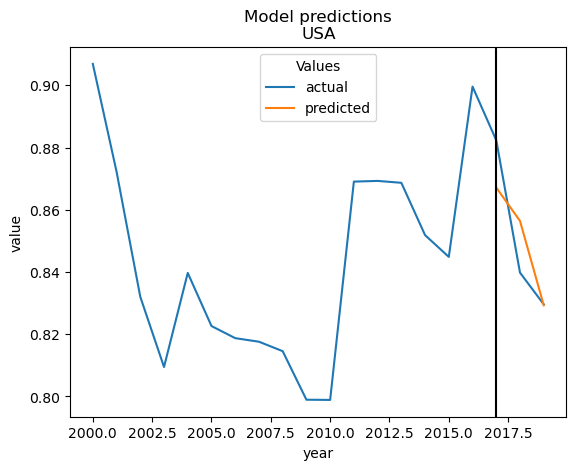

In [12]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2017, color="black")
plt.title("Model predictions\nUSA")

Text(0.5, 1.0, 'Model predictions\nDEU')

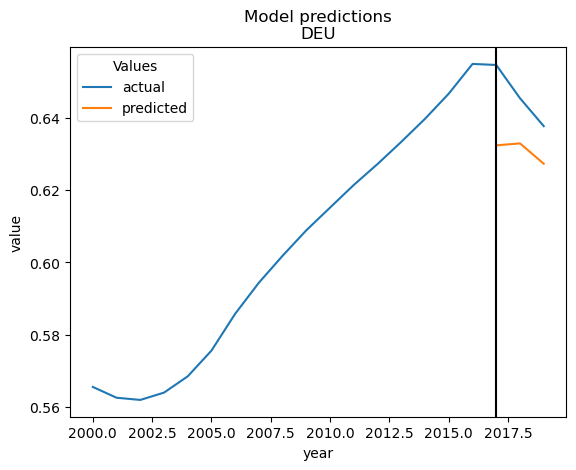

In [13]:
sns.lineplot(
    data=get_forward_pred(lasso_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2017, color="black")
plt.title("Model predictions\nDEU")

## XGBoost-Regressor

In [15]:
xgb = XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 300],
    "max_depth": [3, 5],
    "min_child_weight": [1, 5],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1]
}

grid_search = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=3,  # reduced folds bc of more hyperparams (-> bigger grid)
    scoring="neg_mean_squared_error",
    verbose=1, 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 100, 'subsample': 0.8}


In [16]:
xgb_best = grid_search.best_estimator_
y_hat_test_xgb = xgb_best.predict(X_test)

In [17]:
collect_metrics(y_test, y_hat_test_xgb)

{'MSE': 0.00017924018688116,
 'RMSE': 0.013388061356341328,
 'MAE': 0.004489607317251732,
 'R-squared': 0.8861053625549384}

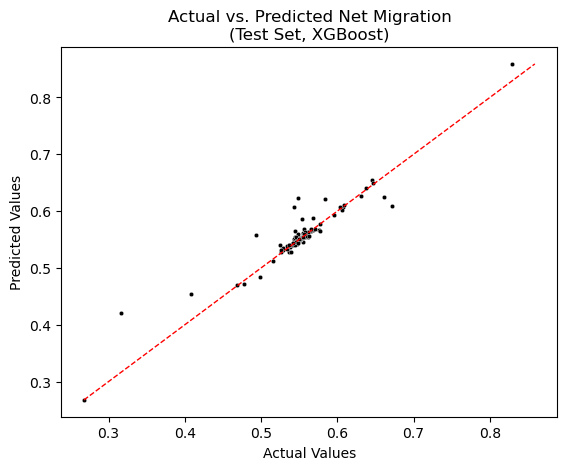

In [18]:
sns.scatterplot(x=y_test, y=y_hat_test_xgb, color="black", s=10)
min_val = min(min(y_test), min(y_hat_test_xgb))
max_val = max(max(y_test), max(y_hat_test_xgb))
plt.plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1)

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Net Migration\n(Test Set, XGBoost)")
plt.show()

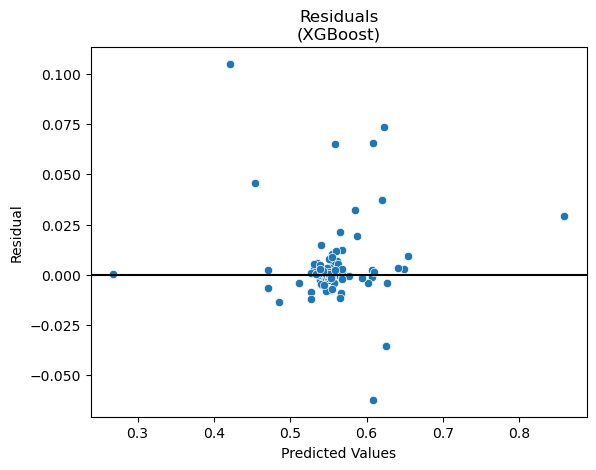

In [19]:
error_xgb = y_hat_test_xgb - y_test
sns.scatterplot(x=y_hat_test_xgb, y=error_xgb)
plt.axhline(y=0, color="black")
plt.xlabel('Predicted Values')
plt.ylabel('Residual')
plt.title('Residuals\n(XGBoost)')
plt.show()

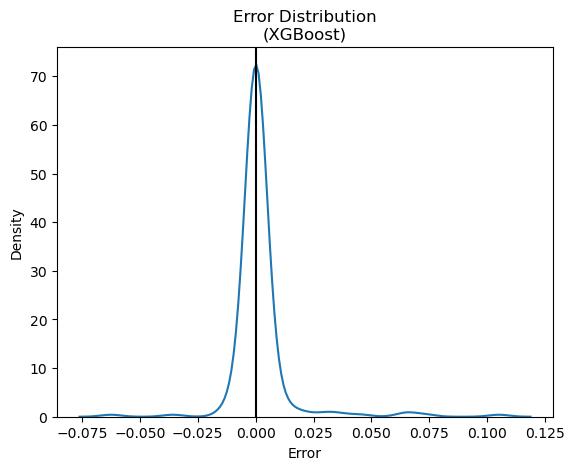

In [20]:
sns.kdeplot(error_xgb)
plt.axvline(x=0, color="black")
plt.xlabel('Error')
plt.ylabel('Density')
plt.title('Error Distribution\n(XGBoost)')
plt.show()

Text(0.5, 1.0, 'Top 10 most important features\n(XGBoost)')

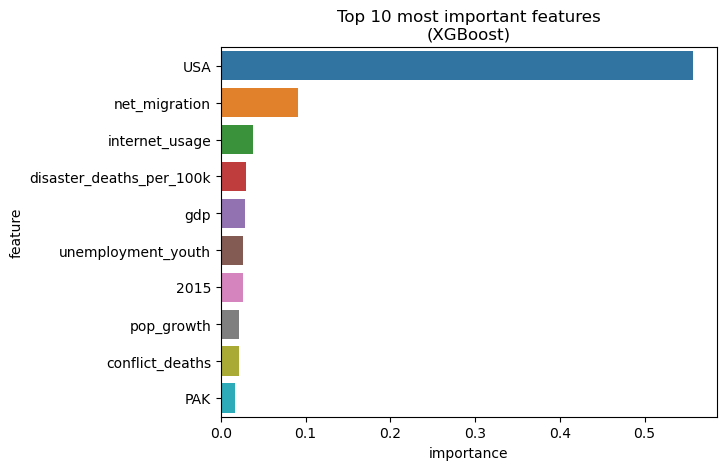

In [23]:
feature_imp = pd.DataFrame({"feature": features, "importance": xgb_best.feature_importances_})
top10_feats = feature_imp.sort_values("importance", ascending=False)[:10]

sns.barplot(
    data=top10_feats,
    x="importance",
    y="feature"
)
plt.title("Top 10 most important features\n(XGBoost)")

# net_migration = net migration in t-1

Text(0.5, 1.0, 'Model predictions\nUSA, XGBoost')

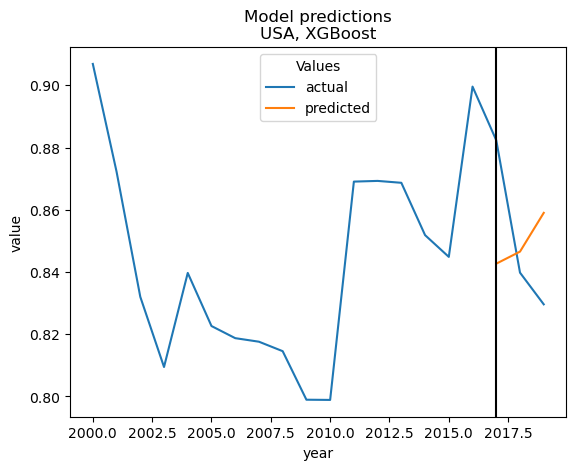

In [25]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "USA"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2017, color="black")
plt.title("Model predictions\nUSA, XGBoost")

Text(0.5, 1.0, 'Model predictions\nDEU, XGBoost')

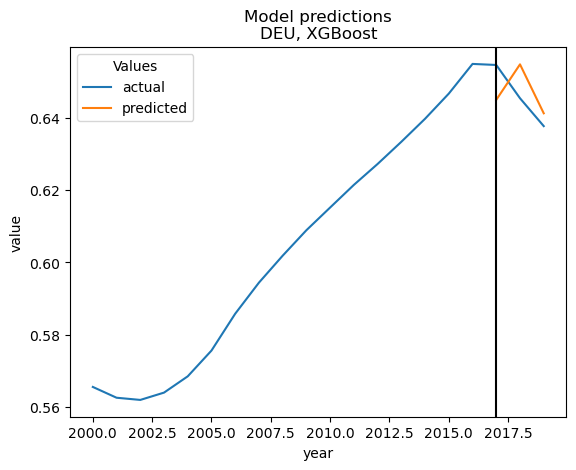

In [28]:
sns.lineplot(
    data=get_forward_pred(xgb_best, "DEU"),
    x="year",
    y="value",
    hue="Values"
)
plt.axvline(x=2017, color="black")
plt.title("Model predictions\nDEU, XGBoost")